In [1]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np

# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt

# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib

# pandas用ライブラリ
import pandas as pd

# データフレーム表示用関数
from IPython.display import display

# seaborn
import seaborn as sns

# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode="fixed")
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams["figure.figsize"] = (6, 6)
# 方眼表示ON
plt.rcParams["axes.grid"] = True
# データフレームでの表示精度
pd.options.display.float_format = "{:.3f}".format
# データフレームですべての項目を表示
pd.set_option("display.max_columns", None)

In [2]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.25.1
Running on ArViz v0.22.0


In [3]:
# アイリスデータセットの読み込み
df = sns.load_dataset("iris")

# 先頭5行の確認
display(df.head())

#  speciesの分布確認
df["species"].value_counts()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

In [4]:
df.head().to_excel("df.xlsx")

In [5]:
# setosaの行のみ抽出
df0 = df.query('species == "setosa"')

# versicolorの行のみ抽出
df1 = df.query('species == "versicolor"')

# virginicaの行のみ抽出
df2 = df.query('species == "virginica"')

# 乱数により3個のインデックスを生成
import random

random.seed(42)
indexes = range(len(df0))
sample_indexes = random.sample(indexes, 3)

# df0, df1, df2のデータ数をそれぞれ3行にする
df0_sel = df0.iloc[sample_indexes]
df1_sel = df1.iloc[sample_indexes]
df2_sel = df2.iloc[sample_indexes]

# 　全部連結して一つにする
df_sel = pd.concat([df0_sel, df1_sel, df2_sel]).reset_index(drop=True)

In [6]:
display(df_sel)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.000,3.500,1.300,0.300,setosa
1,5.000,3.400,1.500,0.200,setosa
2,4.900,3.000,1.400,0.200,setosa
3,5.500,2.600,4.400,1.200,versicolor
4,4.900,2.400,3.300,1.000,versicolor
5,6.400,3.200,4.500,1.500,versicolor
6,6.700,3.100,5.600,2.400,virginica
7,7.300,2.900,6.300,1.800,virginica
8,5.800,2.700,5.100,1.900,virginica


Text(0.5, 1.0, '抽出した計9個の観測値の散布図')

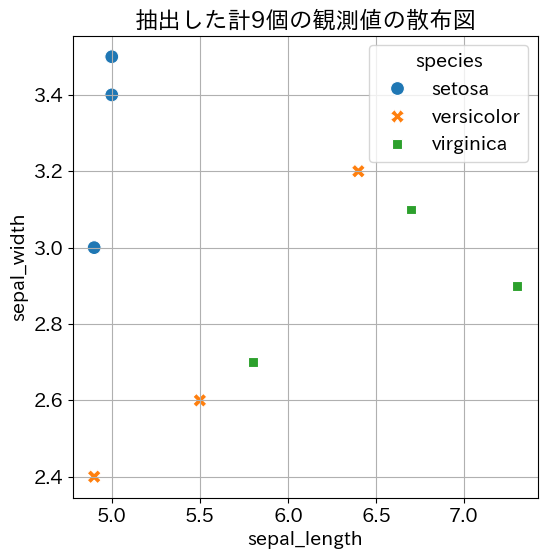

In [7]:
sns.scatterplot(
    x="sepal_length",
    y="sepal_width",
    hue="species",
    style="species",
    data=df_sel,
    s=100,
)
plt.title("抽出した計9個の観測値の散布図")

In [8]:
# sepal_length と sepal_width の列を NumPy 配列として取り出す
# （後で回帰モデルやプロットで使いやすいように、1 次元配列にしておく）
X = df_sel["sepal_length"].values  # 説明変数 X：がく片の長さ
Y = df_sel["sepal_width"].values  # 目的変数 Y：がく片の幅

# 種別ラベル（setosa / versicolor / virginica など）をそのまま取り出す
species = df_sel["species"]

# 種別ラベルをカテゴリ型に変換し，カテゴリごとに 0,1,2,... の整数コードにマッピングする
# （クラスごとに色分けするプロットや、クラスインデックスを持つモデルで使うための前処理）
cl = pd.Categorical(species).codes

# 変換結果の確認：連続値の X, Y、文字列ラベル species、
# そしてそのラベルに対応する整数コード cl がどのように対応しているかを目視でチェックする
print(X)
print(Y)
print(species.values)
print(cl)

[5.000 5.000 4.900 5.500 4.900 6.400 6.700 7.300 5.800]
[3.500 3.400 3.000 2.600 2.400 3.200 3.100 2.900 2.700]
['setosa' 'setosa' 'setosa' 'versicolor' 'versicolor' 'versicolor'
 'virginica' 'virginica' 'virginica']
[0 0 0 1 1 1 2 2 2]


In [9]:
model1 = pm.Model()

with model1:
    # === 観測データノード（通常ベイズと共通）===========================
    # sepal_length と sepal_width の観測値を pm.Data としてグラフに埋め込む。
    # ここでは「説明変数 X と目的変数 Y はすでに観測されている固定値」
    # という前提で、条件付き分布 p(Y | X, θ) だけをモデル化している。
    X_data = pm.Data("X_data", X)
    Y_data = pm.Data("Y_data", Y)

    # クラスインデックス（0,1,2）を pm.Data として保持。
    # setosa / versicolor / virginica ごとに異なる回帰直線を持たせるために、
    # 後で alpha[cl_data], beta[cl_data] という形でクラス別パラメータを引く。
    cl_data = pm.Data("cl_data", cl)

    # === 階層構造の「上位レベル」：クラスごとの傾き α の事前 ============
    # a_mu, a_sigma は「3 クラスの傾き α_k (k=0,1,2) 全体の平均とばらつき」を表す
    # ハイパーパラメータ（集団レベルパラメータ）。
    # a_mu ~ Normal(0, 10^2), a_sigma ~ HalfNormal(10) という広い事前を置くことで、
    # 各クラスの α_k が「共通の正規分布からサンプリングされる」という階層構造をつくる。
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10.0)
    a_sigma = pm.HalfNormal("a_sigma", sigma=10.0)

    # クラス別の傾き α_k（k=0,1,2）。
    # shape=(3,) とすることで α = (α_0, α_1, α_2) を一度に定義している。
    # 理論的には
    #   α_k | a_mu, a_sigma ~ Normal(a_mu, a_sigma^2)
    # となるため、「クラス間で情報を部分的に共有しつつ、それぞれに少しずつ違う傾き」
    # を表現できる。
    alpha = pm.Normal("alpha", mu=a_mu, sigma=a_sigma, shape=(3,))

    # === 階層構造の「上位レベル」：クラスごとの切片 β の事前 ============
    # 傾きと同様に、切片 β_k についても「集団平均 b_mu とばらつき b_sigma」を
    # ハイパーパラメータとして導入する。
    b_mu = pm.Normal("b_mu", mu=0.0, sigma=10.0)
    b_sigma = pm.HalfNormal("b_sigma", sigma=10.0)

    # クラス別の切片 β_k（k=0,1,2）。
    #   β_k | b_mu, b_sigma ~ Normal(b_mu, b_sigma^2)
    # という階層事前になり、クラスごとの回帰直線の位置（切片）が
    # 「共通の分布のまわりに散らばっている」という構造を表現する。
    beta = pm.Normal("beta", mu=b_mu, sigma=b_sigma, shape=(3,))

    # === 誤差標準偏差 ε（通常ベイズと共通）==============================
    # 観測誤差（残差）の大きさを表す標準偏差 ε。
    # HalfNormal(1) を事前に置くことで、「0 以上で、小さい値をやや優先するが、
    # 1 より大きなノイズも排除しない」というソフトな事前知識を表している。
    epsilon = pm.HalfNormal("epsilon", sigma=1.0)

    # === クラス別回帰直線による期待値 μ_i の計算（階層ベイズ固有） ======
    # cl_data は各サンプルがどのクラス（0,1,2）に属するかを表す整数インデックス。
    # alpha[cl_data], beta[cl_data] とすることで、
    #   クラス k に属するサンプル i には α_k, β_k を割り当てる
    # という処理をベクトル化して実装している。
    #
    # 理論的には、各サンプル i について
    #   μ_i = α_{c_i} * X_i + β_{c_i}
    # となる階層ベイズ回帰モデルになっている。
    mu = pm.Deterministic("mu", X_data * alpha[cl_data] + beta[cl_data])

    # === 観測モデル（尤度）：Y の条件付き分布（通常ベイズと共通） ========
    # 期待値 μ_i と誤差標準偏差 ε を用いて、
    #   Y_i | α, β, ε, X_i, c_i ~ Normal(μ_i, ε^2)
    # という条件付き分布を定義する。
    # これが階層ベイズ回帰モデル全体の尤度に対応し、
    # PyMC の pm.sample はこの尤度と事前を組み合わせた事後分布から
    # α, β, a_mu, a_sigma, b_mu, b_sigma, ε などのサンプルを生成する。
    obs = pm.Normal("obs", mu=mu, sigma=epsilon, observed=Y_data)

In [10]:
# ALPHAは要素数３の配列
ALPHA = np.array([0.1, 0.2, 0.3])
print(ALPHA)

# CLは要素数9の配列
CL = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])
print(CL)

# MUも要素数9の配列になる
MU = ALPHA[CL]
print(MU)

[0.100 0.200 0.300]
[0 0 0 1 1 1 2 2 2]
[0.100 0.100 0.100 0.200 0.200 0.200 0.300 0.300 0.300]


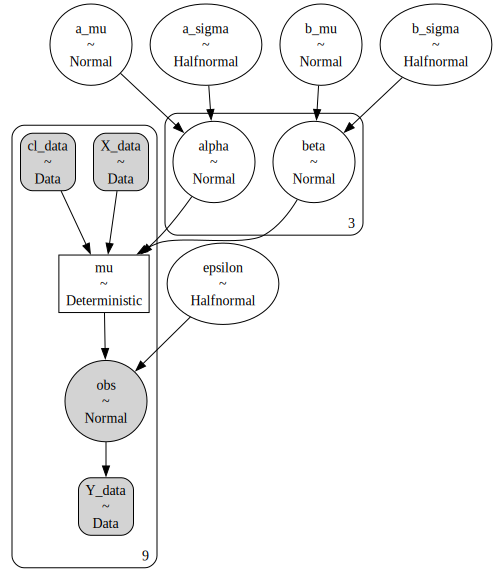

In [11]:
g = pm.model_to_graphviz(model1)
display(g)

In [12]:
with model1:
    idata1 = pm.sample(random_seed=42, target_accept=0.998)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_mu, a_sigma, alpha, b_mu, b_sigma, beta, epsilon]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


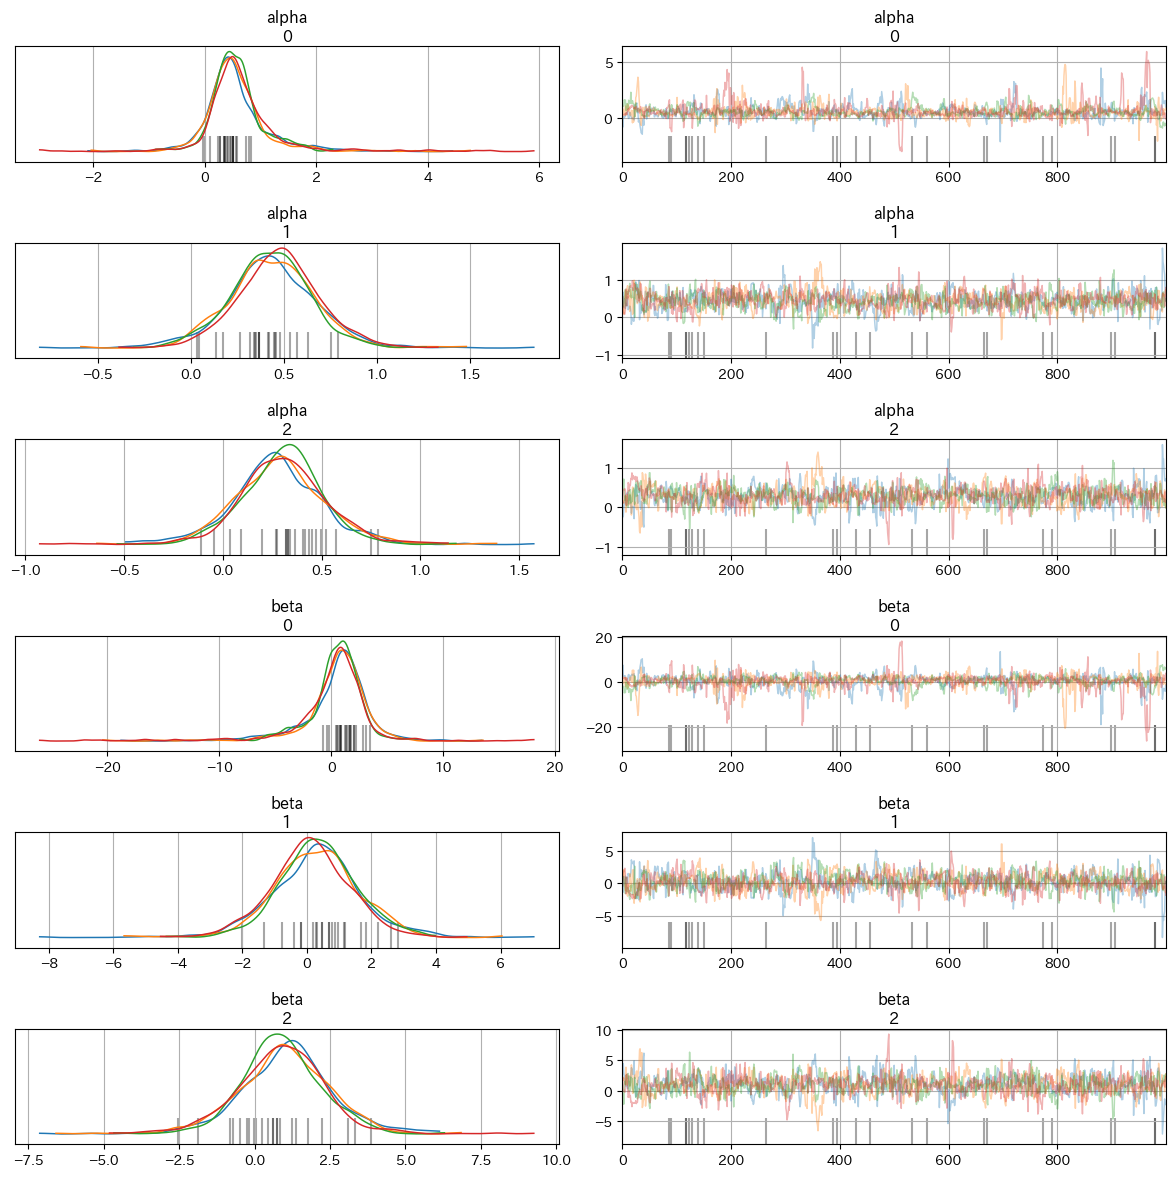

In [13]:
# ArviZの plot_trace を使って、MCMC が生成した事後サンプルの診断（収束・混合の確認）を行う。
# トレースプロットは「左：周辺事後の密度（KDE）」「右：反復に沿った系列」を同時に描き、
# 複数チェーンが同じ事後分布を再現しているか／時間方向にドリフトしていないかを目視でチェックできる。
az.plot_trace(
    idata1,  # PyMC の pm.sample が返した推論結果（事後サンプルを格納した InferenceData）
    compact=False,  # False にすると各チェーンの系列と密度を省略せずに分けて表示し、
    # チェーン間の混合（重なり）や局所的な非収束をより丁寧に観察できる。
    var_names=["alpha", "beta"],  # 表示したい変数のみ指定。
    # 回帰係数 alpha（傾き）と beta（切片）の事後が、
    # 尤度と事前の組み合わせでどの程度絞られ、かつ安定に探索されているかを見る目的。
)

# サブプロットの余白を自動調整して、タイトルや軸ラベルの重なりを防ぐ。
# 図が詰まって読みにくいと、収束診断の解釈ミスにつながるため、可視化の品質確保として重要。
plt.tight_layout()

In [14]:
summary1 = az.summary(idata1, var_names=["alpha", "beta"])
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.587,0.616,-0.287,1.844,0.024,0.048,781.000,748.000,1.000
alpha[1],0.443,0.230,0.007,0.873,0.009,0.008,740.000,1032.000,1.000
alpha[2],0.295,0.226,-0.128,0.712,0.009,0.009,711.000,782.000,1.000
beta[0],0.375,3.061,-5.916,4.667,0.118,0.238,789.000,723.000,1.000
beta[1],0.264,1.305,-2.330,2.610,0.048,0.046,738.000,1027.000,1.000
beta[2],0.955,1.490,-1.688,3.887,0.057,0.056,706.000,868.000,1.000


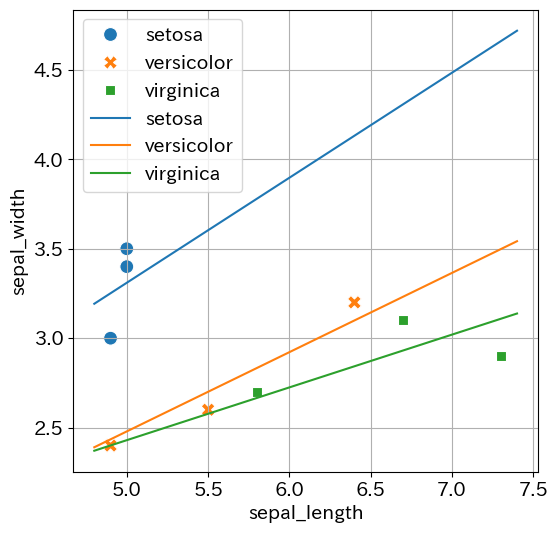

In [15]:
# alphaとbetaの平均値の導出
means = summary1["mean"]
alpha0 = means["alpha[0]"]
alpha1 = means["alpha[1]"]
alpha2 = means["alpha[2]"]
beta0 = means["beta[0]"]
beta1 = means["beta[1]"]
beta2 = means["beta[2]"]

# 回帰直線用座標値の計算
x_range = np.array([X.min() - 0.1, X.max() + 0.1])
y0_range = alpha0 * x_range + beta0
y1_range = alpha1 * x_range + beta1
y2_range = alpha2 * x_range + beta2

# 散布図表示
sns.scatterplot(
    x="sepal_length",
    y="sepal_width",
    hue="species",
    style="species",
    data=df_sel,
    s=100,
)
plt.plot(x_range, y0_range, label="setosa")
plt.plot(x_range, y1_range, label="versicolor")
plt.plot(x_range, y2_range, label="virginica")
plt.legend()

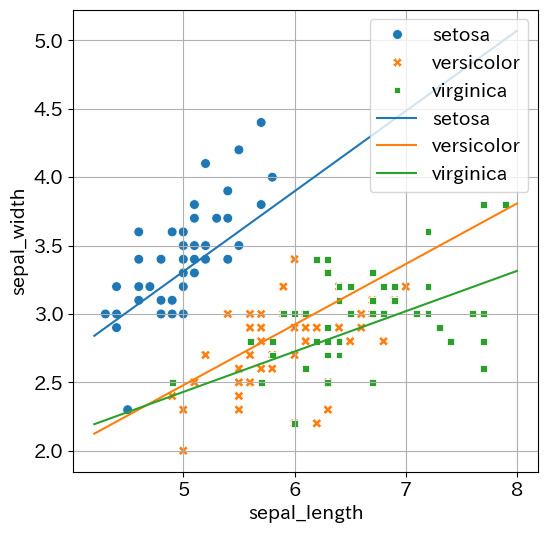

In [16]:
# 回帰直線の座標値計算
x_range = np.array([df["sepal_length"].min() - 0.1, df["sepal_length"].max() + 0.1])
y0_range = alpha0 * x_range + beta0
y1_range = alpha1 * x_range + beta1
y2_range = alpha2 * x_range + beta2

# 散布図表示
sns.scatterplot(
    x="sepal_length", y="sepal_width", hue="species", style="species", s=50, data=df
)
plt.plot(x_range, y0_range, label="setosa")
plt.plot(x_range, y1_range, label="versicolor")
plt.plot(x_range, y2_range, label="virginica")
plt.legend()